**カリブレーション数値(sigma 0.396%)の検証**

In [1]:
import QuantLib as ql ; import matplotlib.pyplot as plt ; import numpy as np 
import pandas as pd ; import myUtil as mu ; from myABBR import *
tradeDT = mu.jDT(2022,8,19) ; mu.setEvDT(tradeDT)
# Tiborカーブ準備
crvDATA = [ ('depo','6m',0.13636),  ('swap','1y',0.15249),  ('swap','18m',0.18742), 
            ('swap','2y',0.20541),  ('swap','3y',0.23156),  ('swap','4y',0.25653), 
            ('swap','5y',0.28528),  ('swap','6y',0.32341),  ('swap','7y',0.36591), 
            ('swap','8y',0.40906),  ('swap','9y',0.45471),  ('swap','10y',0.50224)] 
tbrIX, tbCrvOBJ, tbCrvHDL, tbParRATE = mu.makeTiborCurve(crvDATA)
# check
nodesDF = pd.DataFrame([(dt.ISO(),df) for dt,df in tbCrvOBJ.nodes()], 
                                                                columns=['','DF'])
print("決済日(reference): ", tbCrvOBJ.referenceDate().ISO())
nodesDF[:5].style.format({'DF':'{:.9f}' })

決済日(reference):  2022-08-23


,,DF
0,2022-08-23,1.000000000
1,2023-02-24,0.999309338
2,2023-08-23,0.998476779
3,2024-02-26,0.997170374
4,2024-08-23,0.995895547


In [2]:
# MC初期設定(rSeed:乱数シード番号  mtrxPT:各パスのデータ保存用)
nPATH, nSTEP, YRs,    sigma,    aa,   rSeed, mtrxPT         =\
2,       2,     1,   0.396/100, 0.03,    3,     []  
# x過程と乱数列
xPROC    = ql.ExtendedOrnsteinUhlenbeckProcess(aa, sigma, 0.0, lambda x: 0.0)
gsSeqRNG = ql.GaussianRandomSequenceGenerator(
        ql.UniformRandomSequenceGenerator(nSTEP,ql.UniformRandomGenerator(rSeed)))
rndSEQ   = gsSeqRNG.nextSequence().value(); print('rndSEQ:',rndSEQ)    # checking
gsPathGN = ql.GaussianPathGenerator(xPROC, YRs, nSTEP, gsSeqRNG, False) 

# 各パスのグリッドデータのmtrxPTへの保存(nextメソッドで乱数を発生、valueで値を取得)
for nn in range(nPATH):
    onePT = gsPathGN.next().value()     
    mtrxPT.append([onePT[ii] for ii in range(len(onePT))])
# 最後のonePTから時間軸を作成 (timeメソッドで時間軸の値を取得)    
timeGRD = [onePT.time(ii) for ii in range(len(onePT))]
print('timeGRD  : ',timeGRD) ; print('mtrxPT: ',mtrxPT)
endX = np.array(mtrxPT)[:,-1] ; print('endX:',endX[:2])    # endXは各パスの最後の値

rndSEQ: (0.12767750725046909, -1.4704136361301596)
timeGRD  :  [0.0, 0.5, 1.0]
mtrxPT:  [[0.0, 0.0015229909011613956, 0.004263603909036631], [0.0, -0.0015306663718557812, -0.004755098971343507]]
endX: [ 0.0042636 -0.0047551]


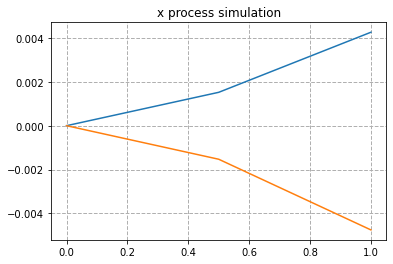

In [3]:
# パスplot
fig, ax = plt.subplots()
for ii in range(nPATH): ax.plot(timeGRD, mtrxPT[ii])
ax.set_title("x process simulation")
ax.grid(linestyle='--',linewidth=1);     

In [4]:
# 原資産の条件, スケジュール:fixSCD, ストライク:strkRT
effDT,                     matDT,        ntlAMT,     cpnRT,      strkRT       =\
mu.jDT(2023,8,23), mu.jDT(2028,8,23), 10_000_000,  0.3579/100,  0.3579/100 
fixSCD = ql.Schedule(effDT, matDT, pdFreqSA, calJP, mFLLW, mFLLW, dgRULEb, EoMf)

#cfYR:キャッシュフロー日までの年数, tnrLST:テナー, nowDF:現在のDF
cfYR   = [dcA365.yearFraction(tbCrvOBJ.referenceDate(), dd) for dd in fixSCD]
tnrLST = np.diff([dcA365.yearFraction(fixSCD.startDate(), dd) for dd in fixSCD])
nowDF = [tbCrvOBJ.discount(dd) for dd in fixSCD]

# 一覧df
dfSCD = pd.DataFrame(dict( cfYR=cfYR, tnrLST=np.append(0,tnrLST), nowDF=nowDF ))
dfSCD.style.format({'cfYR':'{:.3f}', 'tnrLST':'{:.3f}'})

,cfYR,tnrLST,nowDF
0,1.000,0.000,0.998477
1,1.512,0.512,0.997170
2,2.003,0.490,0.995896
3,2.512,0.510,0.994457
4,3.008,0.496,0.993059
5,3.510,0.501,0.991408
6,4.005,0.496,0.989777
7,4.510,0.504,0.987776
8,5.003,0.493,0.985823
9,5.510,0.507,0.983253


In [5]:
# A関数 B関数
def BB(tt,TT):
    return (1-np.exp(-aa*(TT-tt)))/aa
def AA(tt,TT):
    return -0.25* sigma**2 *BB(tt,TT)*(BB(tt,TT)*BB(0,2*tt)+2* BB(0,tt)**2)

# HW価格式の係数
fwdLST = np.array([ii/dfSCD.nowDF[0]    for ii in dfSCD.nowDF])
aaLST  = np.array([AA(dfSCD.cfYR[0], ii) for ii in dfSCD.cfYR]) 
bbLST  = np.array([BB(dfSCD.cfYR[0], ii) for ii in dfSCD.cfYR]) 
# 各パスの最後のX(endX)を使い、1年先のイールドカーブから
# 原資産キャッシュフロー日のDF(HW価格)を計算
pathDF = [fwdLST * np.exp( aaLST - ii*bbLST) for ii in endX] ; pathDF[:2] 

[array([1.        , 0.9965233 , 0.99320809, 0.98968779, 0.98630096,
        0.9826767 , 0.97913099, 0.97522491, 0.97144375, 0.96703987,
        0.96277495]),
 array([1.        , 1.00110307, 1.00209586, 1.00297313, 1.00379017,
        1.00433649, 1.0048413 , 1.00496777, 1.00505711, 1.0045342 ,
        1.00398932])]

In [6]:
#ITMレート計算 (annu:アニュイティ)
annu  = np.array([(ii*np.array(dfSCD.tnrLST)).sum() for ii in pathDF])
itmRT = np.array([(ii[0]-ii[-1]) for ii in pathDF])/annu - strkRT 
print('itmRT(before): ', itmRT[:2])

# マイナス要素をゼロへ置き換え (condIX:マイナス要素flag)
condIX = np.where(itmRT<0) ; itmRT[condIX] = 0 
print('itmRT(after) : ', itmRT[:2])

# スワップション価格
swptnNPV = np.array([itmRT*annu]).sum() / nPATH * ntlAMT * dfSCD.nowDF[0]
print(f'swptnNPV: {swptnNPV:,.2f}')

itmRT(before):  [ 0.00400627 -0.004373  ]
itmRT(after) :  [0.00400627 0.        ]
swptnNPV: 98,154.96
